# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
# import numpy as np
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

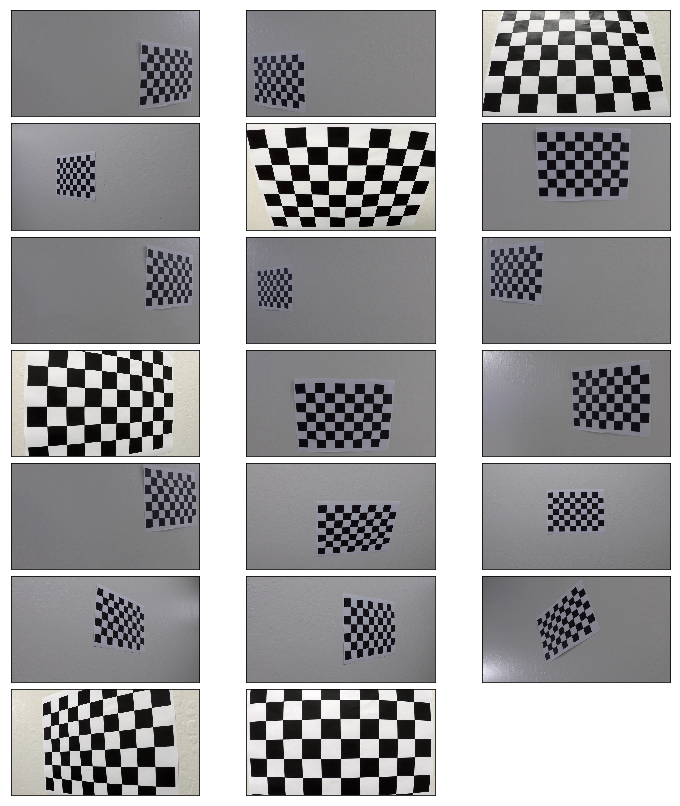

In [2]:
import glob
def plot_images(images, cmap=None):
    cols = 3
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
test_images = [plt.imread(path) for path in glob.glob('camera_cal/*.jpg')]

plot_images(test_images)

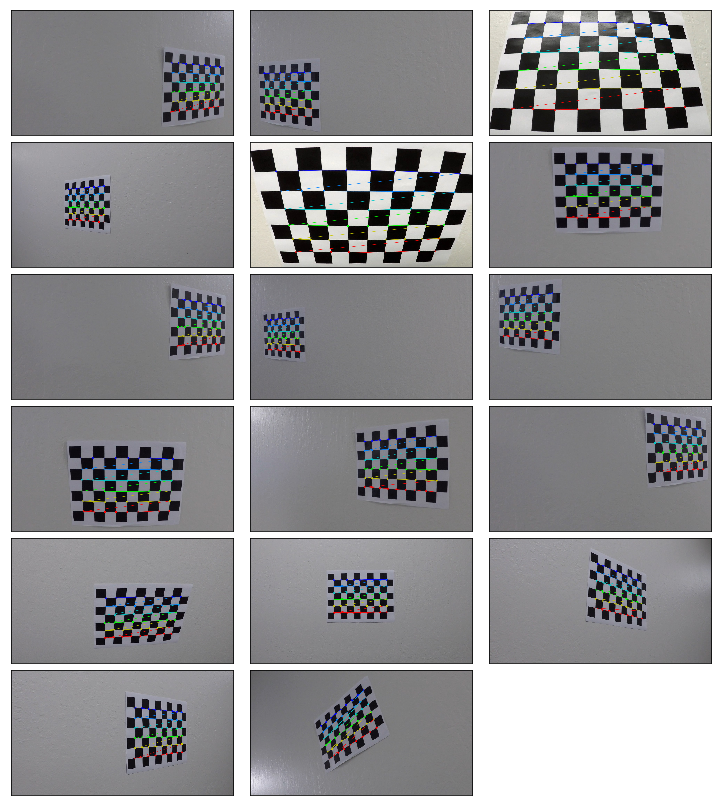

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
display=[]

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Step through the list and search for chessboard corners
for i,fname in enumerate(test_images):
    gray = cv2.cvtColor(fname,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img=cv2.drawChessboardCorners(fname, (9,6), corners, ret)
        display.append(img)
plot_images(display)

In [4]:
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    sobelxy=np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    mask=np.zeros_like(absgraddir)
    mask[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return mask

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

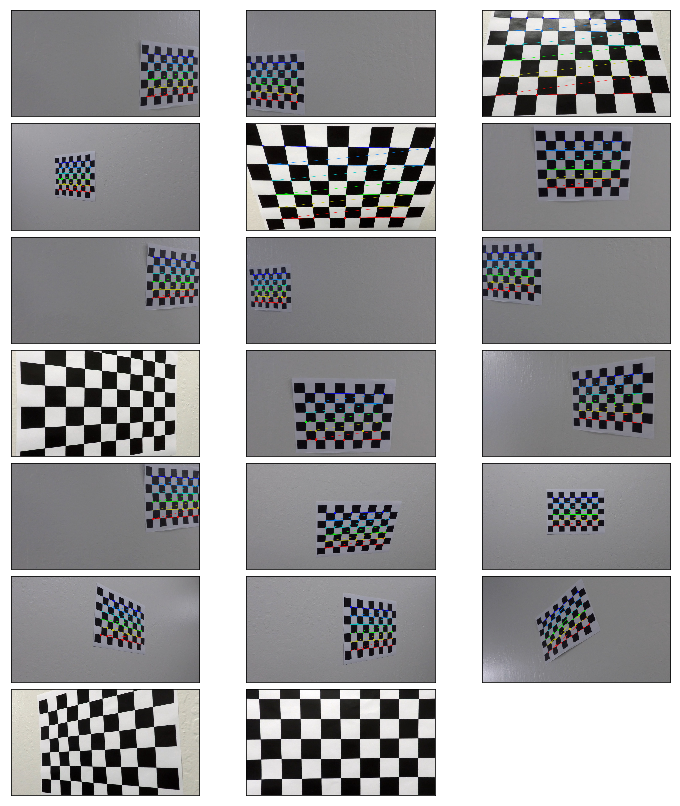

In [5]:
undistort_list=(list(map(cal_undistort,test_images)))
plot_images(undistort_list)

# Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first code cell of the IPython notebook located in "./examples/example.ipynb" (or in lines # through # of the file called `some_file.py`).  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

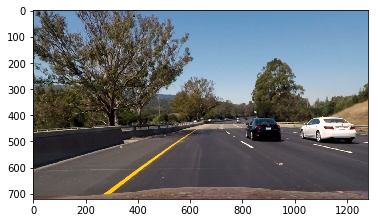

In [6]:
img = plt.imread("test_images/test6.jpg")
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)
plt.show()

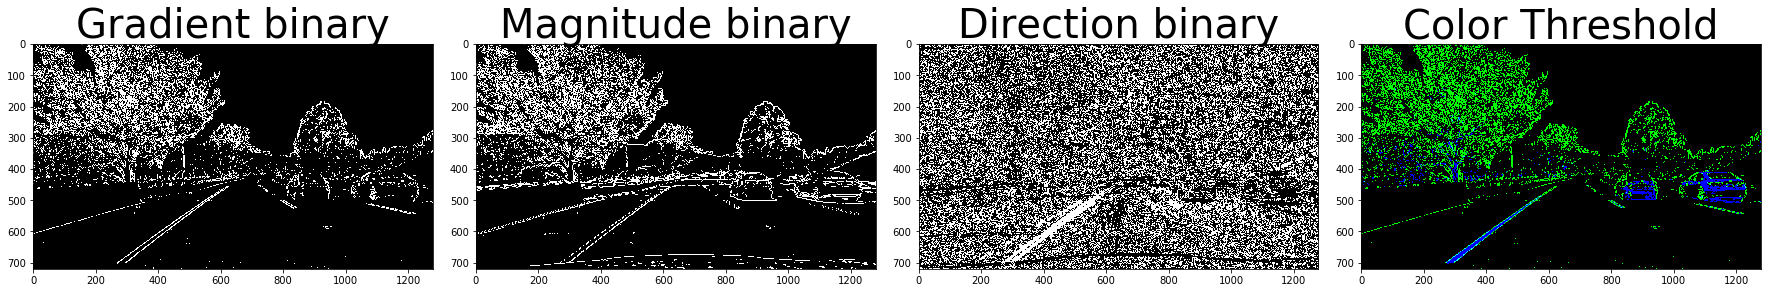

In [7]:
grad_binary = abs_sobel_thresh(undist, orient='x', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(undist, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3))
result = pipeline(undist)

f, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize=(24, 9))
f.tight_layout()

ax1.imshow(grad_binary,cmap='gray')
ax1.set_title('Gradient binary', fontsize=40)
ax2.imshow(mag_binary,cmap='gray')
ax2.set_title('Magnitude binary', fontsize=40)
ax3.imshow(dir_binary,cmap='gray')
ax3.set_title("Direction binary",fontsize=40)
ax4.imshow(result)
ax4.set_title("Color Threshold",fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Text(0.5,1,u'Binary Warped Image')

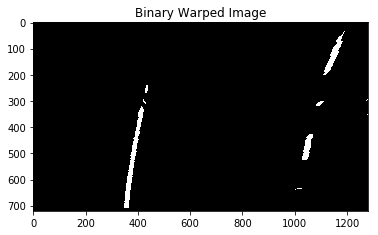

In [8]:
img_size = (img.shape[1],img.shape[0])

thresh = (180, 255)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

src = np.float32([
    [  585,   460 ],
    [  203,   720 ],
    [ 1127,   720 ],
    [  695 ,460 ]])

dst = np.float32([
    [  320, 0  ],
    [  320, 720 ],
    [ 960, 720 ],
    [  960, 0  ]])

M = cv2.getPerspectiveTransform(src, dst)
binary_warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped Image')

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

class Lane:
    def __init__(self,img,camera_calibration_img_path = "camera_cal/calibration*.jpg"):
        self.img_size = (img.shape[1], img.shape[0])
        self.width, self.height = self.img_size
        offset = 200
        src = np.float32([
            [  588,   446 ],
            [  691,   446 ],
            [ 1126,   673 ],
            [  153 ,   673 ]])
        dst = np.float32([[offset, 0], [self.img_size[0] - offset, 0], [self.img_size[0] - offset, self.img_size[1]], [offset, self.img_size[1]]])
        self.M = cv2.getPerspectiveTransform(src,dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
               
        self.ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
        self.y_eval = 700
        self.midx = 640
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

        
    def undistort(self,img):
        return cv2.undistort(img, mtx, dist, None, mtx)
    
    def white_yellow_mask(self,img):
        rgbimg = np.copy(img)
        hls = cv2.cvtColor(rgbimg, cv2.COLOR_RGB2HLS).astype(np.float)
        ##white color
        lower_white = np.array([0,210,0], dtype=np.uint8)
        upper_white = np.array([255,255,255], dtype=np.uint8)
        white_mask = cv2.inRange(hls, lower_white, upper_white)
        ## Yellow Color
        lower_yellow = np.array([18,0,100], dtype=np.uint8)
        upper_yellow = np.array([30,220,255], dtype=np.uint8)
        yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)  
        combined_binary = np.zeros_like(white_mask)
        combined_binary[((white_mask == 255) | (yellow_mask == 255))] = 255
        combined_binary[(combined_binary == 255)] = 1
        return combined_binary
    
    def find_curvature(self,binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        #print(binary_warped.shape[0]/2)
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        y1 = (2*self.left_fit[0]*self.y_eval + self.left_fit[1])*self.xm_per_pix/self.ym_per_pix
        y2 = 2*self.left_fit[0]*self.xm_per_pix/(self.ym_per_pix*self.ym_per_pix)

        curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
        #print("Radius of Curvature: %f" % curvature)
        return curvature
    
    def draw_curves(self,binary_warped,undistorted_img,curvature):
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 

        # Combine the result with the original image
        result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

        cv2.putText(result,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

        x_left_pix = self.left_fit[0]*(self.y_eval**2) + self.left_fit[1]*self.y_eval + self.left_fit[2]
        x_right_pix = self.right_fit[0]*(self.y_eval**2) + self.right_fit[1]*self.y_eval + self.right_fit[2]
        position_from_center = ((x_left_pix + x_right_pix)/2 - self.midx -30) * self.xm_per_pix
        if position_from_center < 0:
            text = 'left'
        else:
            text = 'right'
        cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        return result
        #plt.imshow(result)
    
    
    def curvature(self,img):
        mask=self.white_yellow_mask(img)
        warped_img=cv2.warpPerspective(mask,self.M, (self.width, self.height))
        curvature = self.find_curvature(warped_img)
        result = self.draw_curves(warped_img,img,curvature)
        return result

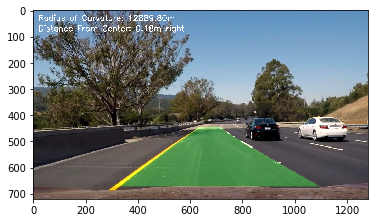

In [10]:
ld = Lane(gray)
plt.imshow(ld.curvature(img))

In [11]:
from moviepy.editor import VideoFileClip
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(ld.curvature) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:59<00:00,  5.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 51s, sys: 3.18 s, total: 1min 54s
Wall time: 4min 2s


In [12]:
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()
output='project_video_output.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.01007616/28549024 bytes (3.5%2727936/28549024 bytes (9.6%5414912/28549024 bytes (19.09297920/28549024 bytes (32.613377536/28549024 bytes (46.9%17498112/28549024 bytes (61.3%21618688/28549024 bytes (75.7%25567232/28549024 bytes (89.6%28549024/28549024 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg.linux64.
